In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../')
from score.scores import ScoreContainer
from settings import proteins, paths, stats
from containers import Protein

mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

/Users/jpaggi/schrodinger.ve/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from settings import feature_defs

def plot():
    protein = Protein(prot, stats['stats41'], paths)

    root = '{}/{}/scores/{}'.format(path, prot, scores)
    stats_root = '{}/{}/scores/{}'.format(path, prot, _stats)
    
    sc = ScoreContainer(root, stats_root, prot, protein.lm.st)

    cluster = sc.read_results(fname)
    glide_cluster = {lig:0 for lig in cluster}
    print(cluster)

    l_list = list(cluster.keys())
    
    
    combind_rmsds = [sc.ps.get_rmsd({lig: cluster[lig]}) for lig in l_list]
    glide_rmsds = [sc.ps.get_rmsd({lig: glide_cluster[lig]}) for lig in l_list]
    f, ax = plt.subplots(figsize = (5, 5))
    ax.scatter(glide_rmsds, combind_rmsds, s = 30, c = 'k')
    ax.plot(range(11), c = 'grey')


    for x, y, lig in zip(glide_rmsds, combind_rmsds, l_list):
        x_shift, y_shift = 0.2, 0.2
        ax.text(x+x_shift, y+y_shift, lig, size = 10, name = 'monospace')


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim(0)
    ax.set_ylim(ax.get_xlim())

    ax.set_ylabel('ComBind RMSD (Å)', size = 18)
    ax.set_xlabel('Glide RMSD (Å)', size = 18)
    plt.tight_layout()
    plt.show()
    

    interactions = sc.ps.interactions([cluster, glide_cluster],  'hbond')
    unique, keys = [], set()
    for code, res in interactions[::-1]:
        if res not in keys:
            unique += [(code, res)]
        keys.add(res)

    sc.ps.gel_plot_individual(cluster, 'hbond', l_list, interactions=interactions, resname_size = 14)
    plt.scatter(range(0, 2*len(combind_rmsds), 2), [-1]*len(combind_rmsds),
                c = np.array(combind_rmsds) < 2.1, cmap='binary', vmin=0, vmax=1)
    plt.show()

    sc.ps.gel_plot_individual(glide_cluster, 'hbond', l_list, interactions=interactions, resname_size = 14)
    plt.scatter(range(0, 2*len(glide_rmsds), 2), [-1]*len(glide_rmsds),
                c = np.array(glide_rmsds) < 2.1, cmap='binary', vmin=0, vmax=1)
    plt.show()
    
    
    interactions = sc.ps.interactions([cluster, glide_cluster],  'sb')
    unique, keys = [], set()
    for code, res in interactions[::-1]:
        if res not in keys:
            unique += [(code, res)]
        keys.add(res)

    sc.ps.gel_plot_individual(cluster, 'sb', l_list, interactions=interactions, resname_size = 14)
    plt.scatter(range(0, 2*len(combind_rmsds), 2), [-1]*len(combind_rmsds),
                c = np.array(combind_rmsds) < 2.1, cmap='binary', vmin=0, vmax=1)
    plt.show()

    sc.ps.gel_plot_individual(glide_cluster, 'sb', l_list, interactions=interactions, resname_size = 14)
    plt.scatter(range(0, 2*len(glide_rmsds), 2), [-1]*len(glide_rmsds),
                c = np.array(glide_rmsds) < 2.1, cmap='binary', vmin=0, vmax=1)
    plt.show()

B2AR
{'3D4S_lig': 0, '3NY8_lig': 3, '3NY9_lig': 3, '3NYA_lig': 0, '3P0G_lig': 1, '4LDL_lig': 0, '4LDO_lig': 4}


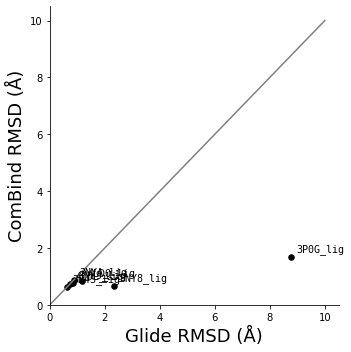

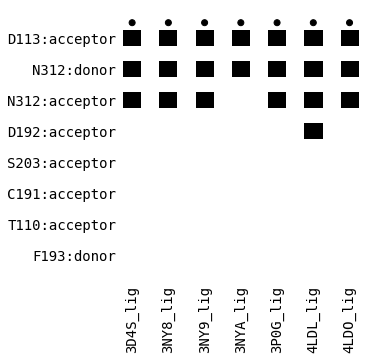

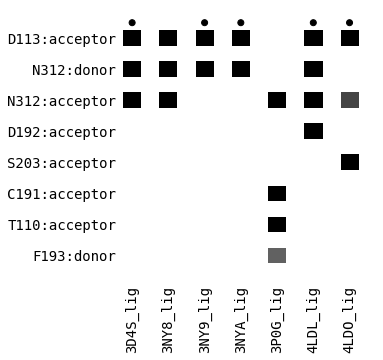

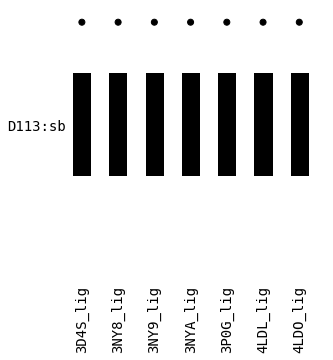

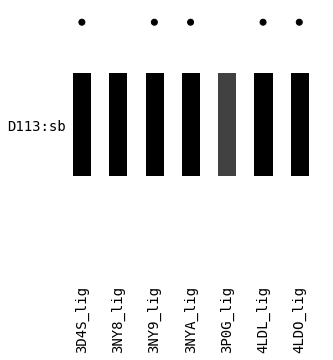

B1AR
{'2Y00_lig': 45, '2Y02_lig': 0, '2Y03_lig': 56, '2Y04_lig': 37, '2YCW_lig': 1, '2YCZ_lig': 3, '3ZPQ_lig': 2, '3ZPR_lig': 9, '4AMI_lig': 1, '4AMJ_lig': 1, '5A8E_lig': 4}


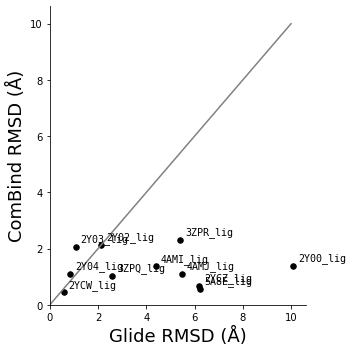

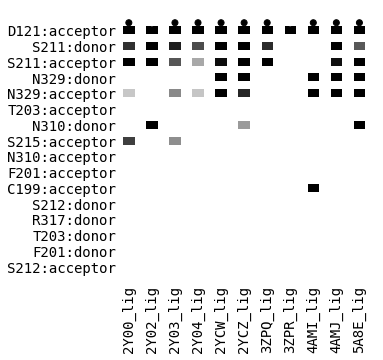

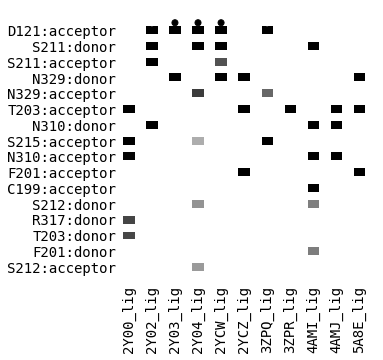

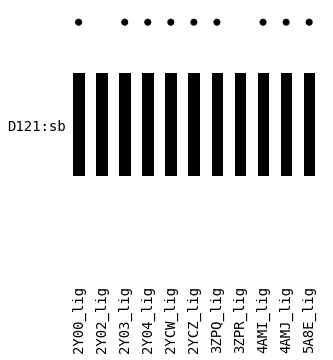

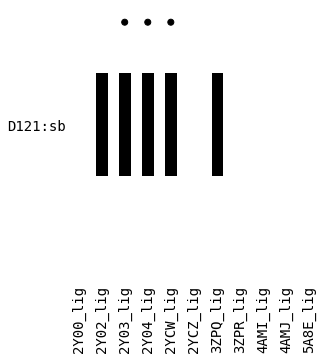

DAT
{'4XNU_lig': 0, '4XNX_lig': 2, '4XP1_lig': 2, '4XP4_lig': 20, '4XP5_lig': 10, '4XP6_lig': 0, '4XP9_lig': 0, '4XPA_lig': 15}


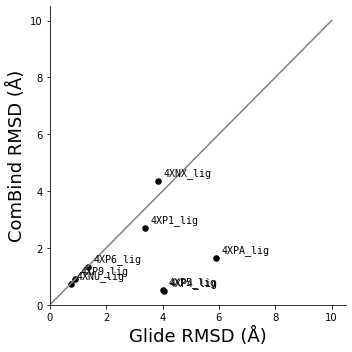

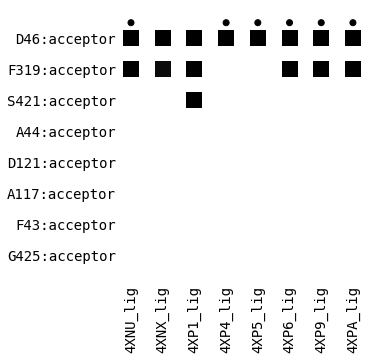

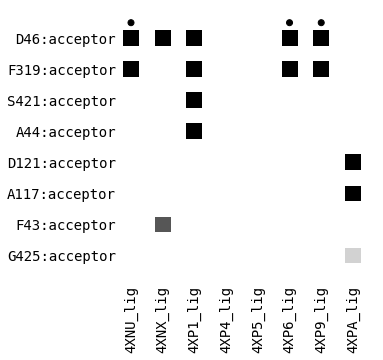

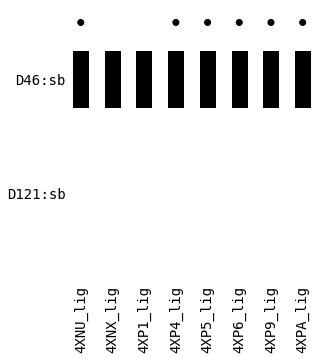

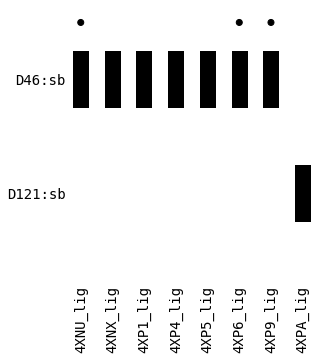

PLAU
{'1C5Y_lig': 0, '1C5Z_lig': 0, '1EJN_lig': 0, '1F5L_lig': 2, '1GI7_lig': 0, '1GJ7_lig': 0, '1GJ8_lig': 0, '1GJA_lig': 4, '1GJC_lig': 1, '1GJD_lig': 5, '1O3P_lig': 4, '1O5A_lig': 0, '1O5C_lig': 0, '1OWE_lig': 0, '1OWH_lig': 1, '1SQA_lig': 2, '1SQO_lig': 0, '1SQT_lig': 1, '1W0Z_lig': 23, '1W11_lig': 14}


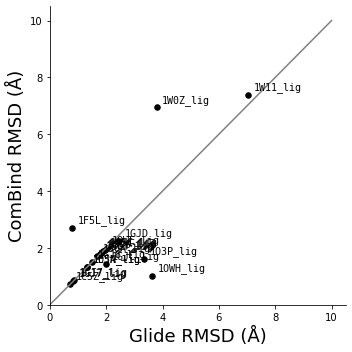

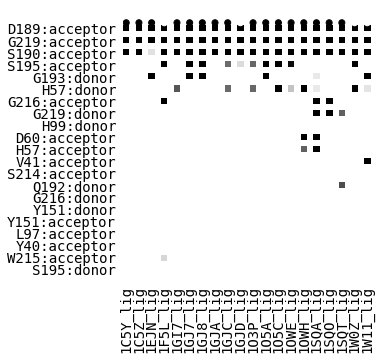

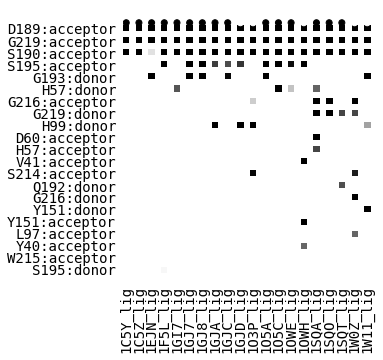

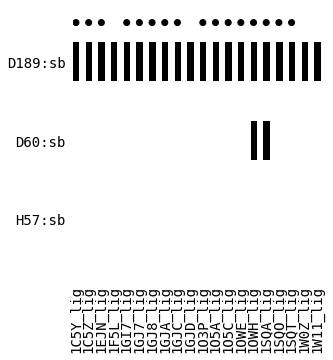

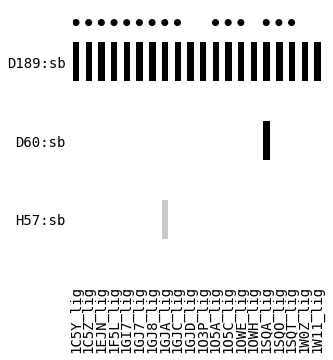

PTPN1
{'1BZJ_lig': 0, '1C83_lig': 5, '1C84_lig': 2, '1C86_lig': 2, '1C88_lig': 1, '1ECV_lig': 4, '1G7F_lig': 26, '1G7G_lig': 6, '1GFY_lig': 0, '1KAV_lig': 63, '1L8G_lig': 1, '1NL9_lig': 7, '1NNY_lig': 10, '1NO6_lig': 27, '1NWL_lig': 5, '1NZ7_lig': 5, '1ONY_lig': 6, '1ONZ_lig': 41, '1PYN_lig': 0, '1QXK_lig': 0}


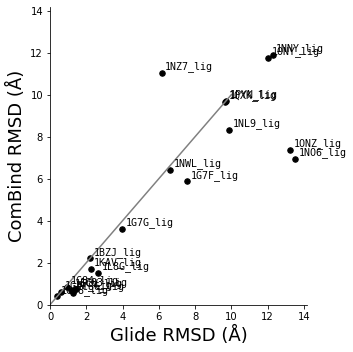

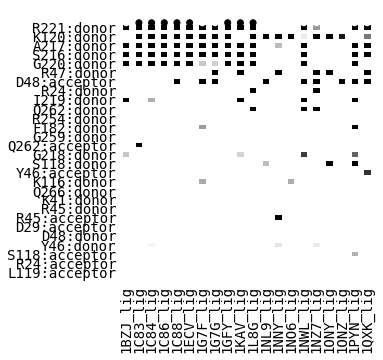

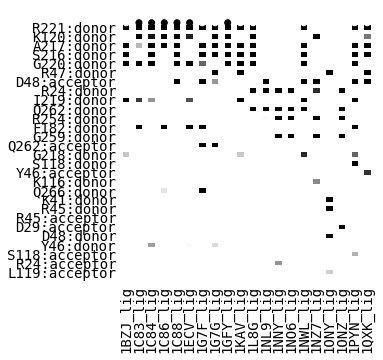

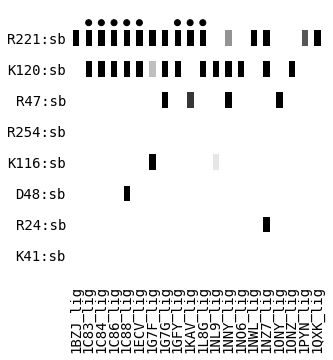

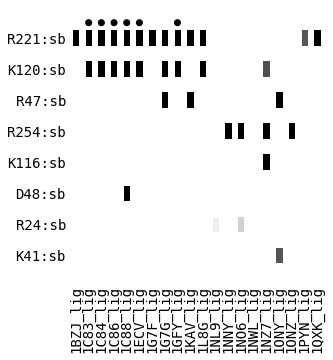

BACE1
{'1M4H_lig': 0, '2FDP_lig': 3, '2G94_lig': 0, '2P4J_lig': 0, '2QMG_lig': 0, '2VKM_lig': 1, '3BRA_lig': 0, '3BUF_lig': 24, '3BUG_lig': 12, '3BUH_lig': 2, '3CKP_lig': 0, '3I25_lig': 1, '3KMX_lig': 0, '3KMY_lig': 1, '3L59_lig': 5, '3LPI_lig': 0, '3LPK_lig': 4, '3RSX_lig': 0, '3RU1_lig': 0, '3UDH_lig': 0}


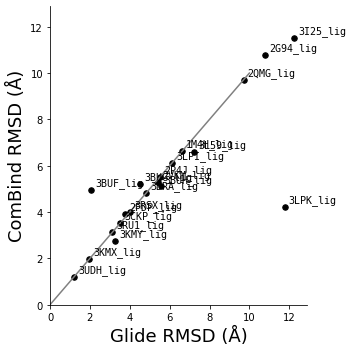

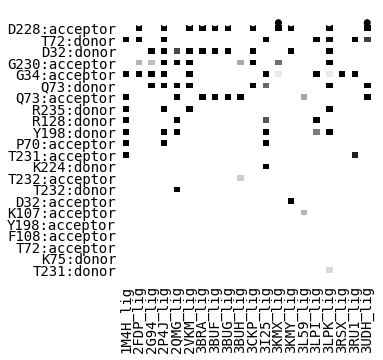

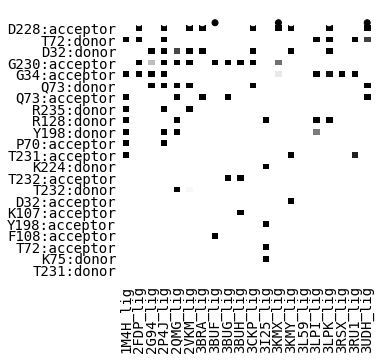

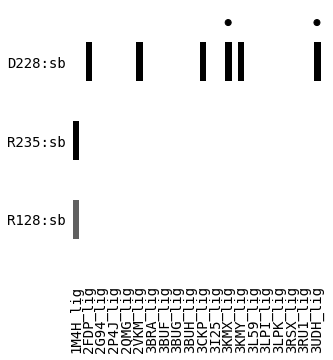

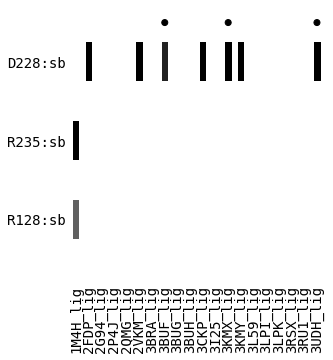

F10
{'1F0R_lig': 0, '1F0S_lig': 1, '1FJS_lig': 0, '1G2L_lig': 0, '1KSN_lig': 1, '1LPG_lig': 0, '1LPK_lig': 1, '1LPZ_lig': 12, '1MQ5_lig': 3, '1MQ6_lig': 0, '1NFU_lig': 0, '1NFW_lig': 6, '1NFX_lig': 0, '1NFY_lig': 1, '1XKA_lig': 2, '1Z6E_lig': 3, '2BOH_lig': 0, '2BOK_lig': 2, '2BQ7_lig': 0, '2J2U_lig': 11}


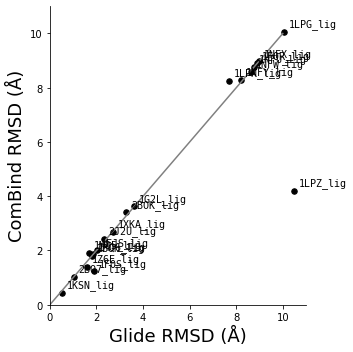

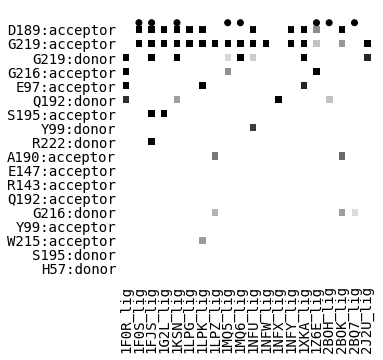

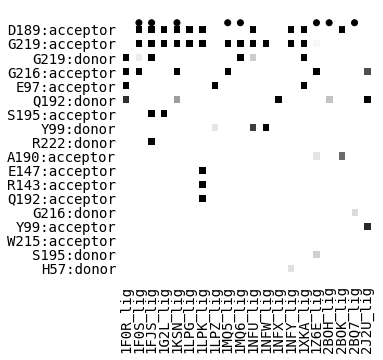

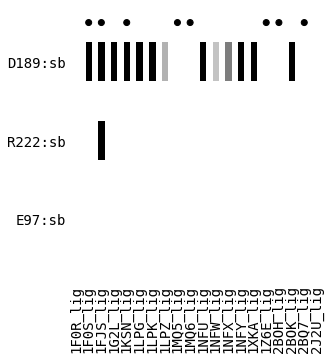

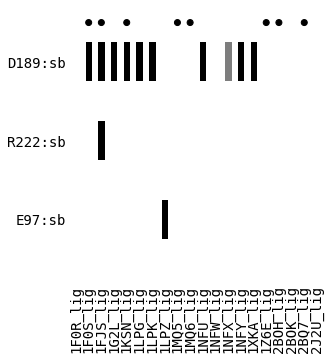

SIGMAR1
{'5HK2_lig': 2, '6DJZ_lig': 0, '6DK0_lig': 0, '6DK1_lig': 0}


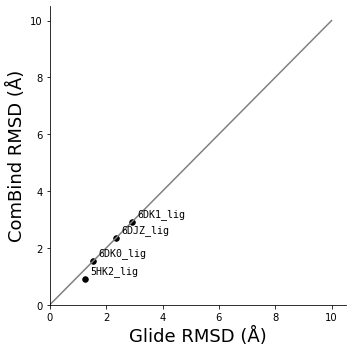

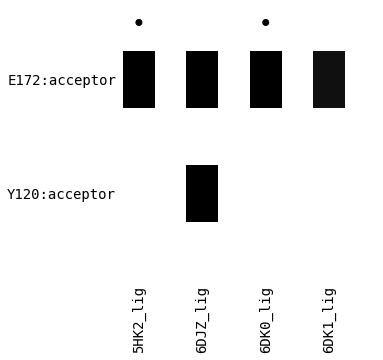

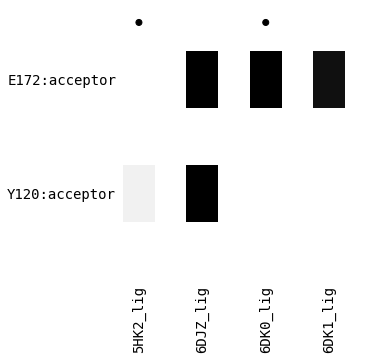

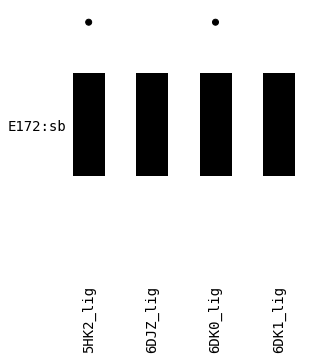

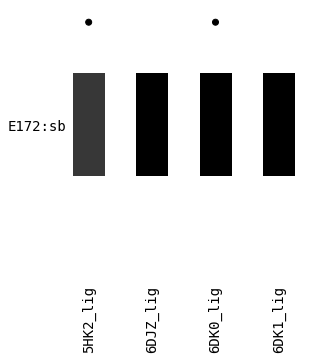

MGLUR5
{'5CGC_lig': 12, '5CGD_lig': 2, '6FFH_lig': 16, '6FFI_lig': 0}


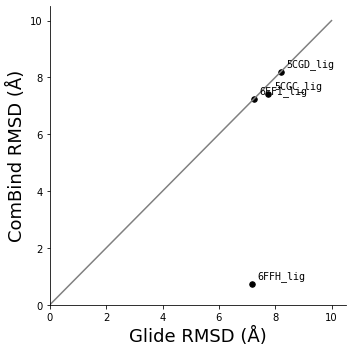

failed
ELANE
{'5A09_lig': 0, '5A0A_lig': 12, '5A0B_lig': 0, '5A0C_lig': 0, '5A8X_lig': 11, '5A8Y_lig': 0, '5A8Z_lig': 0, '5ABW_lig': 0}


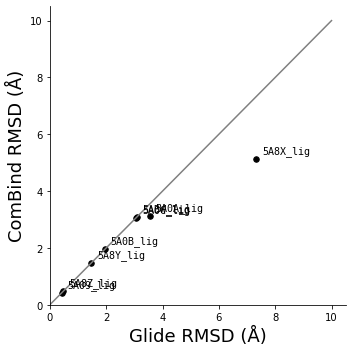

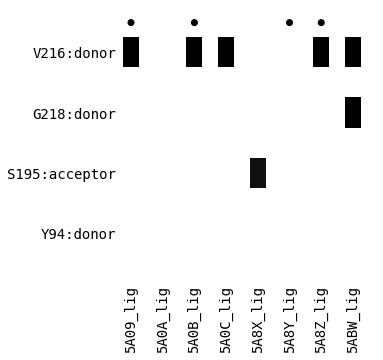

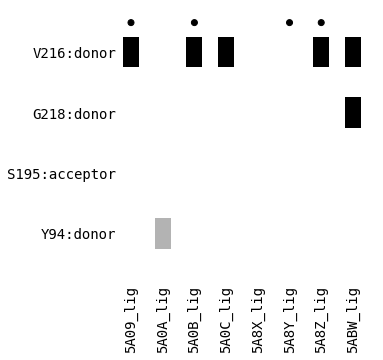

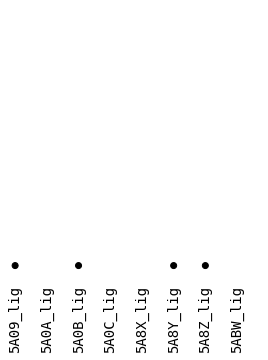

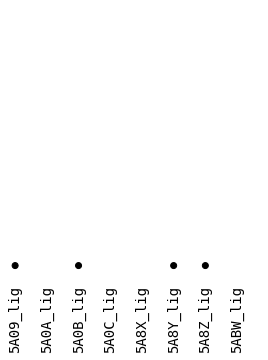

5HT2B
{'5TVN_lig': 23, '6DRX_lig': 0, '6DRY_lig': 0, '6DRZ_lig': 3, '6DS0_lig': 0}


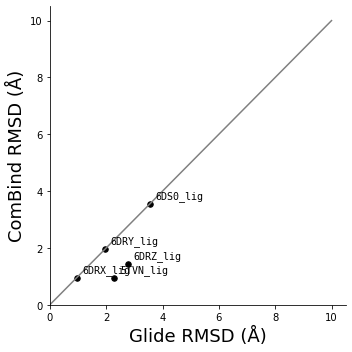

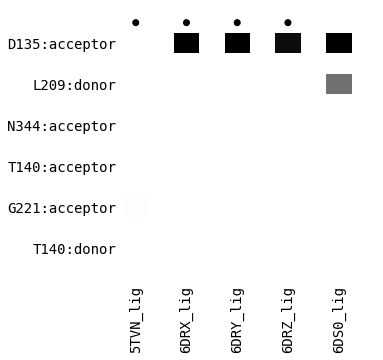

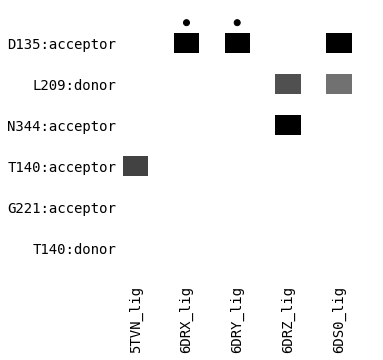

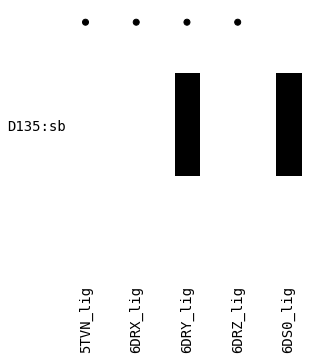

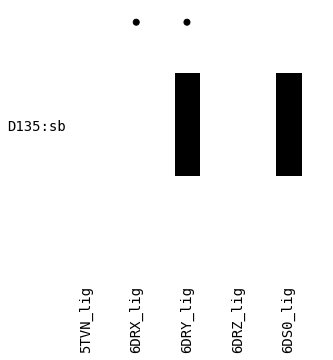

DHFR
{'1DLR_lig': 0, '1DLS_lig': 0, '1HFP_lig': 0, '1KMS_lig': 1, '1KMV_lig': 0, '1OHJ_lig': 8, '1PD8_lig': 0, '2W3A_lig': 2, '3GHC_lig': 75, '3GHW_lig': 2, '3GYF_lig': 0, '3NTZ_lig': 12, '3NU0_lig': 2, '3NXO_lig': 0, '3NXR_lig': 1, '3NXT_lig': 0, '3NXV_lig': 1, '3NXY_lig': 1, '4DDR_lig': 0, '4KAK_lig': 2}


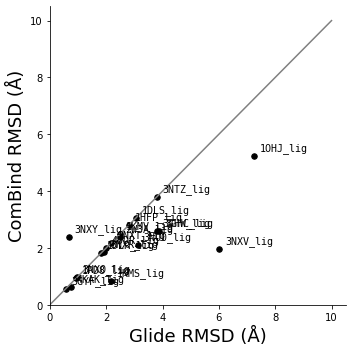

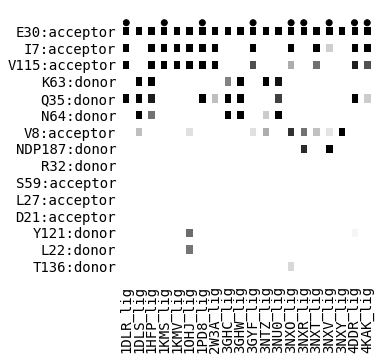

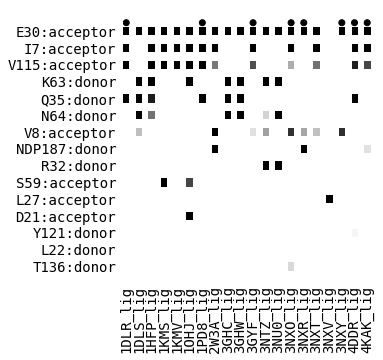

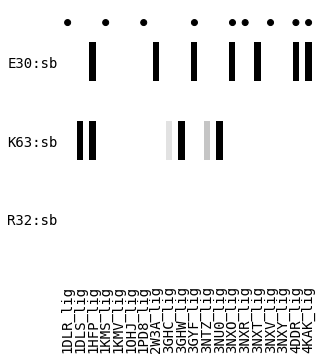

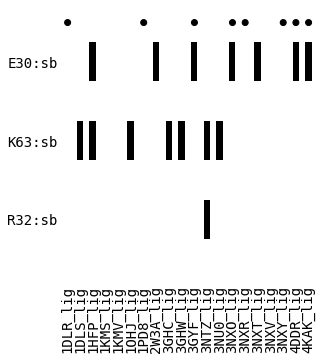

SMO
{'4N4W_lig': 15, '4QIM_lig': 0, '5L7I_lig': 30, '5V57_lig': 0}


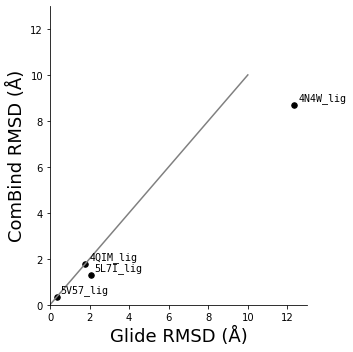

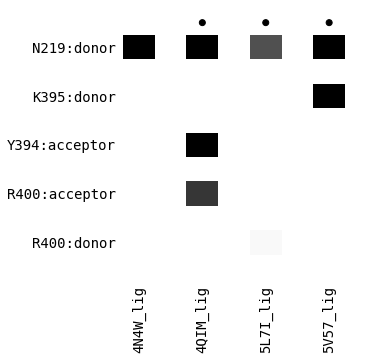

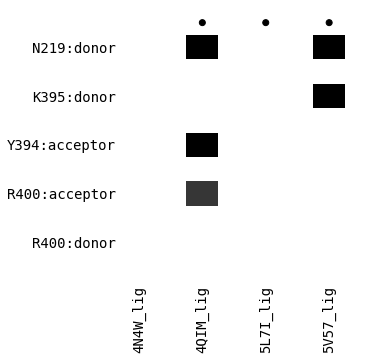

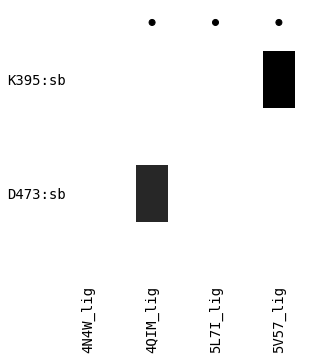

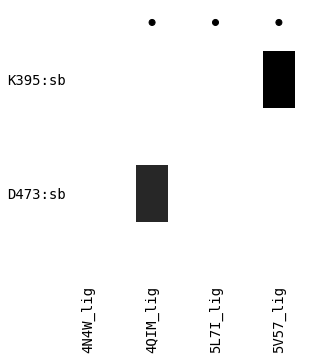

BRD4
{'3P5O_lig': 0, '3U5J_lig': 4, '3U5L_lig': 1, '3ZYU_lig': 7, '4LYW_lig': 11, '4LZR_lig': 4, '4LZS_lig': 2, '4MR3_lig': 87, '4NUC_lig': 39, '4NUE_lig': 0, '4OGJ_lig': 1, '4QB3_lig': 0, '4WIV_lig': 24, '4XYA_lig': 2, '4Z93_lig': 5, '5ACY_lig': 0}


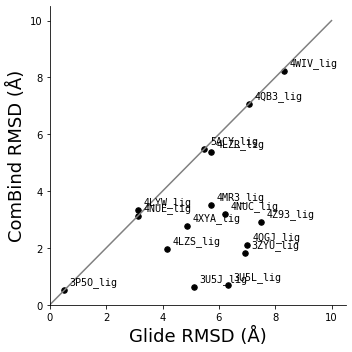

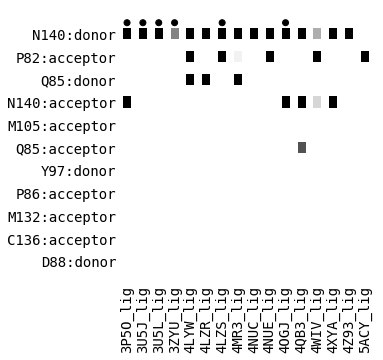

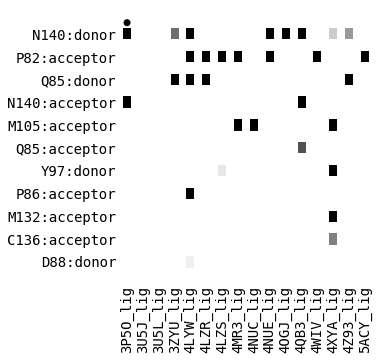

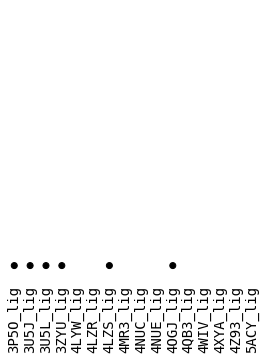

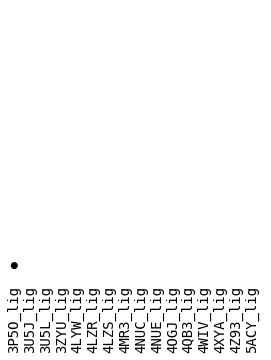

P00760
{'1BJV_lig': 1, '1BTY_lig': 0, '1C1R_lig': 1, '1C5Q_lig': 0, '1C5S_lig': 0, '1C5T_lig': 0, '1EB2_lig': 1, '1F0T_lig': 0, '1F0U_lig': 0, '1G36_lig': 0, '1G3D_lig': 3, '1G3E_lig': 0, '1GHZ_lig': 0, '1GI1_lig': 0, '1GJ6_lig': 0, '1K1I_lig': 0, '1K1J_lig': 0, '1K1L_lig': 0, '1K1M_lig': 1, '1K1N_lig': 1}


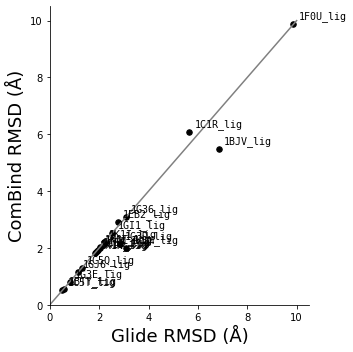

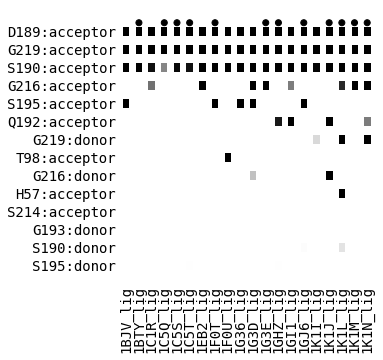

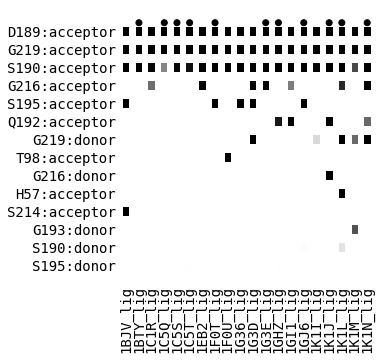

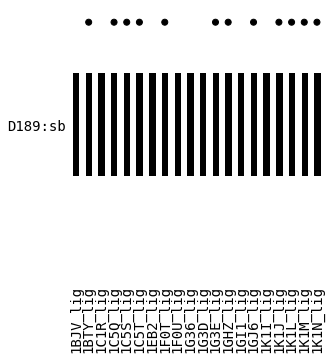

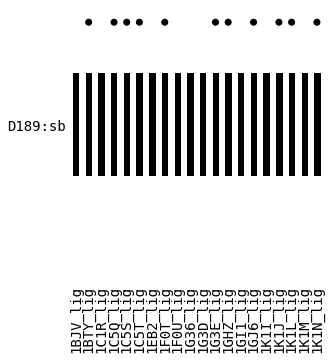

CDK2
{'1CKP_lig': 1, '1DI8_lig': 0, '1DM2_lig': 0, '1E1V_lig': 9, '1E1X_lig': 1, '1E9H_lig': 7, '1FIN_lig': 3, '1FVT_lig': 2, '1FVV_lig': 2, '1G5S_lig': 6, '1GIH_lig': 1, '1GIJ_lig': 2, '1GZ8_lig': 0, '1H0V_lig': 0, '1H1Q_lig': 0, '1H1R_lig': 0, '1H1S_lig': 0, '1JSV_lig': 2, '1JVP_lig': 0, '1KE5_lig': 0}


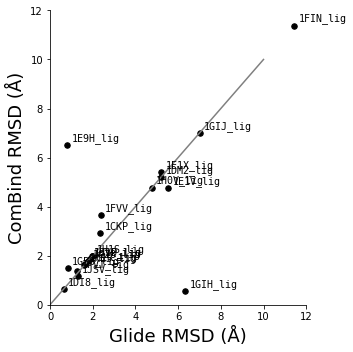

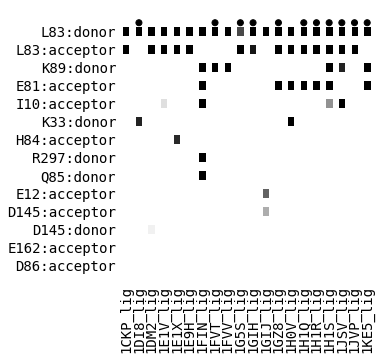

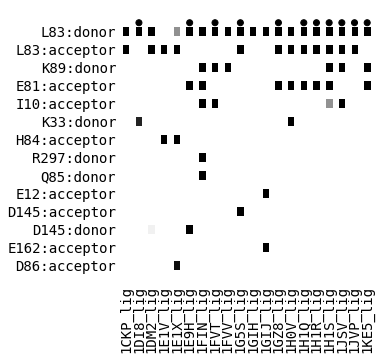

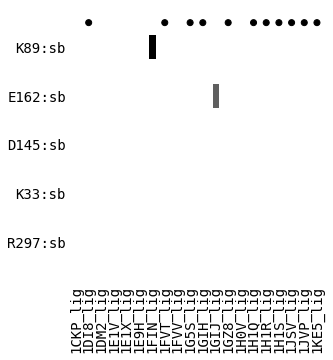

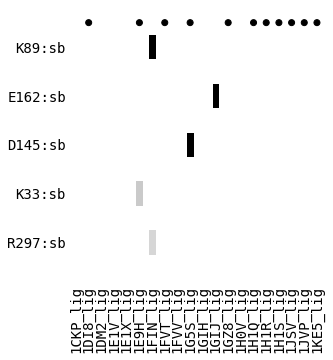

NR3C2
{'2A3I_lig': 0, '2AA2_lig': 0, '2AA5_lig': 0, '2AA7_lig': 0, '3VHV_lig': 0, '3WFG_lig': 0, '4PF3_lig': 2, '5HCV_lig': 0, '5L7E_lig': 0, '5L7G_lig': 0, '5MWP_lig': 0, '5MWY_lig': 0}


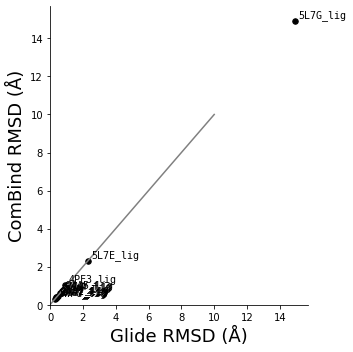

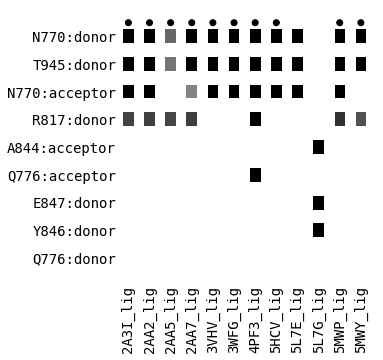

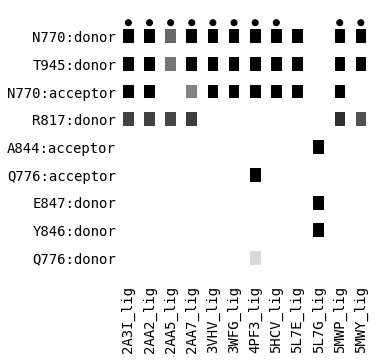

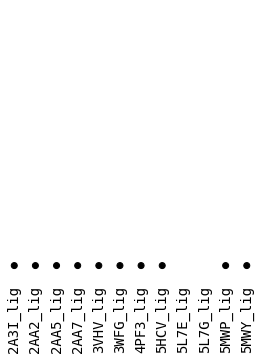

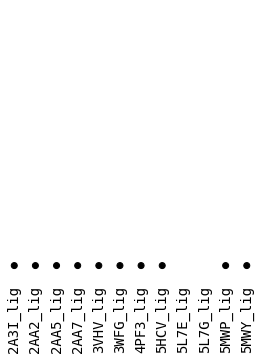

GLUT1
{'5EQH_lig': 43, '5EQI_lig': 0}


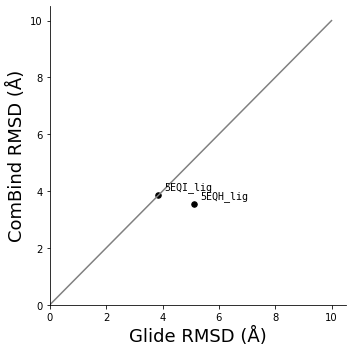

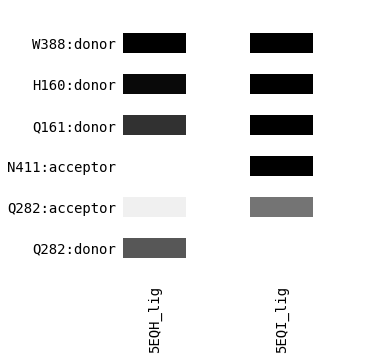

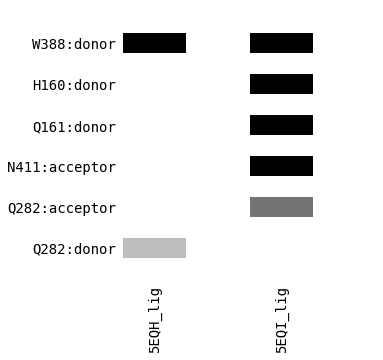

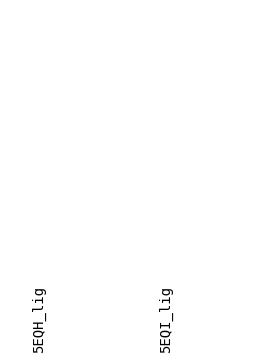

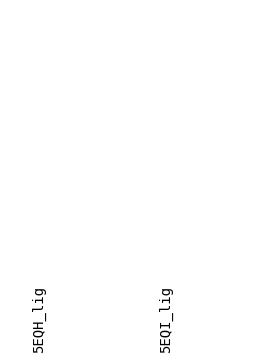

VDR
{'1IE8_lig': 2, '1S0Z_lig': 0, '1S19_lig': 0, '1TXI_lig': 0, '2HAM_lig': 1, '2HAR_lig': 0, '2HAS_lig': 0, '2HB7_lig': 0, '2HB8_lig': 0, '3A2I_lig': 0, '3A3Z_lig': 0, '3A40_lig': 0, '3A78_lig': 2, '3AUQ_lig': 0, '3AX8_lig': 0, '3AZ1_lig': 4, '3AZ2_lig': 0, '3AZ3_lig': 1, '3B0T_lig': 0, '3CS4_lig': 0}


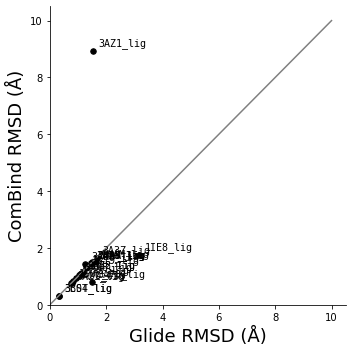

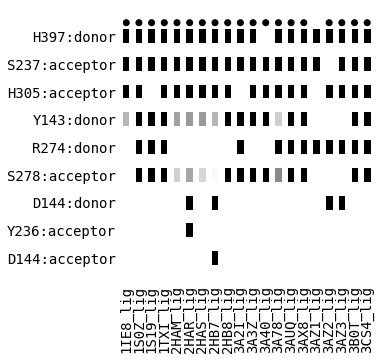

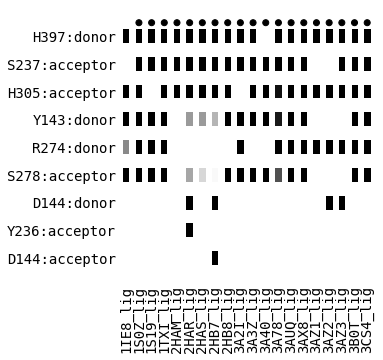

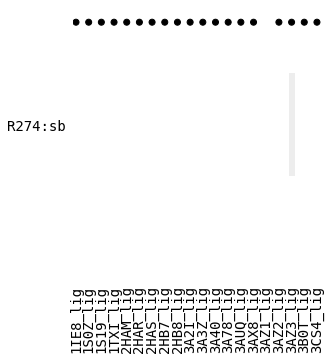

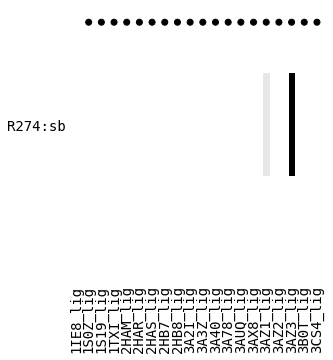

PDE10A
{'3UUO_lig': 14, '4DFF_lig': 3, '4HF4_lig': 20, '4LKQ_lig': 1, '4LLJ_lig': 22, '4LLK_lig': 5, '4LLP_lig': 81, '4LLX_lig': 0, '4LM0_lig': 8, '4LM1_lig': 2, '4LM2_lig': 63, '4LM3_lig': 23, '4LM4_lig': 13, '4MRW_lig': 7, '4MRZ_lig': 5, '4MSA_lig': 3, '4MSC_lig': 2, '4MSN_lig': 2, '4ZO5_lig': 15, '5C1W_lig': 15}


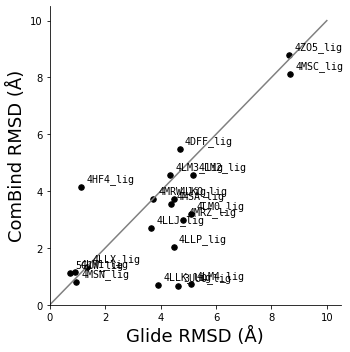

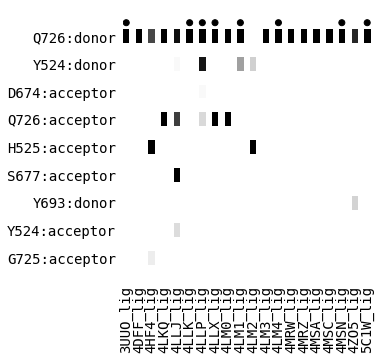

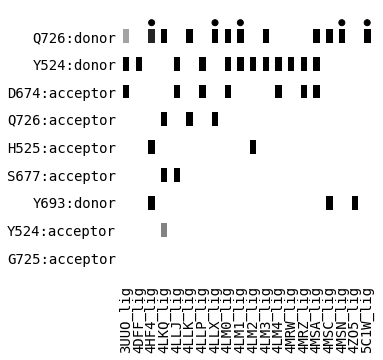

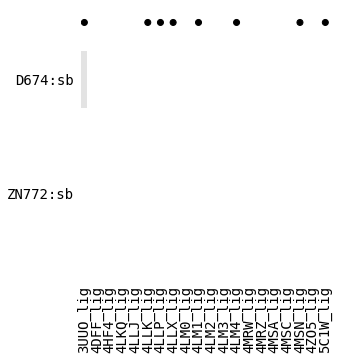

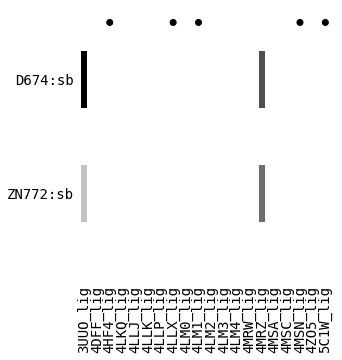

PYGM
{'2G9Q_lig': 43, '2PYI_lig': 0, '2QRG_lig': 0, '2QRH_lig': 0, '2QRM_lig': 13, '2QRP_lig': 0, '2QRQ_lig': 0, '3G2H_lig': 1, '3G2I_lig': 18, '3G2J_lig': 0, '3G2K_lig': 1, '3G2L_lig': 0, '3G2N_lig': 45, '3L79_lig': 2, '3L7A_lig': 0, '3L7B_lig': 1, '3L7C_lig': 0, '3L7D_lig': 2, '3SYM_lig': 13, '3SYR_lig': 0}


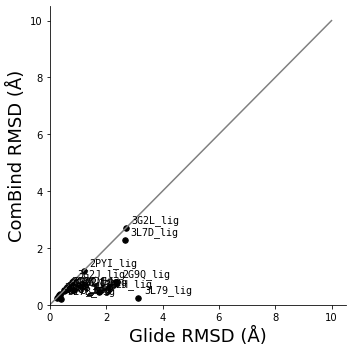

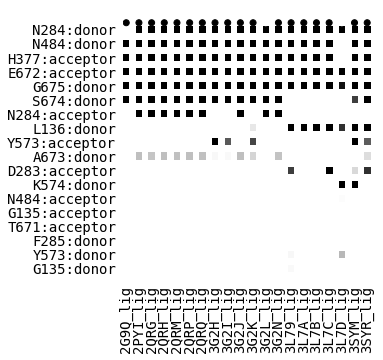

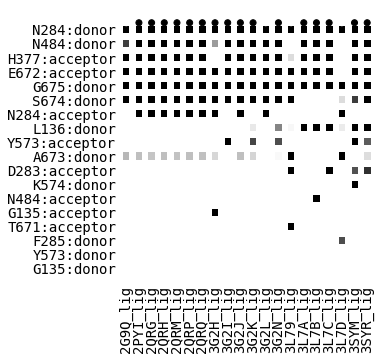

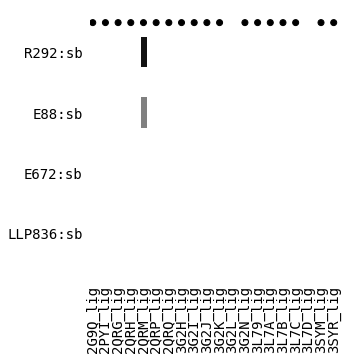

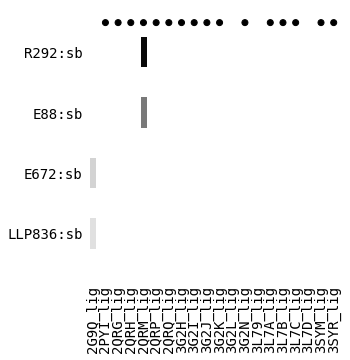

NR3C1
{'1P93_lig': 10, '3CLD_lig': 0, '3E7C_lig': 0, '3K22_lig': 0, '4CSJ_lig': 1, '4MDD_lig': 0, '4P6W_lig': 0, '4P6X_lig': 2, '4UDD_lig': 1, '5G3J_lig': 0, '5G5W_lig': 0, '5NFP_lig': 27, '5NFT_lig': 0, '6EL6_lig': 0, '6EL7_lig': 0, '6EL9_lig': 5}


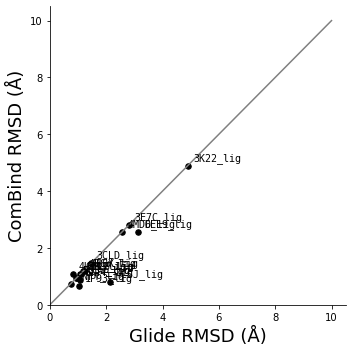

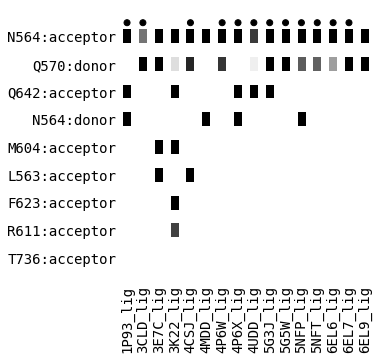

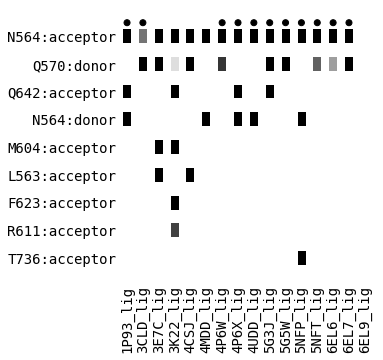

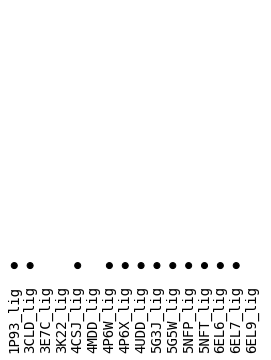

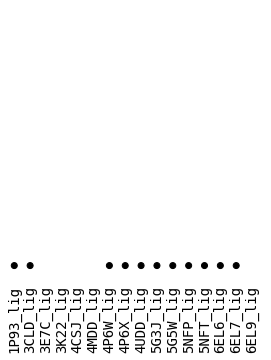

SLC6A4
{'5I71_lig': 6, '5I74_lig': 5, '6AWO_lig': 1, '6AWP_lig': 0}


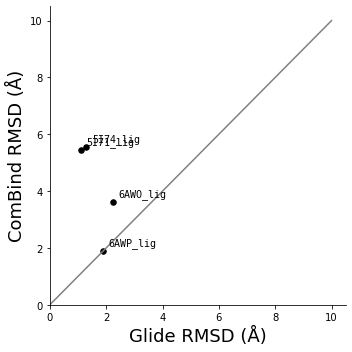

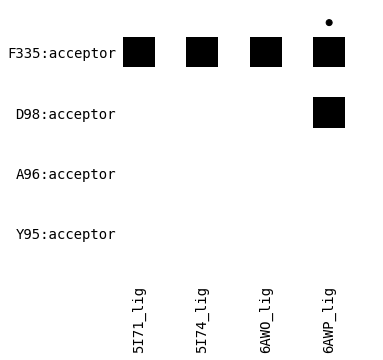

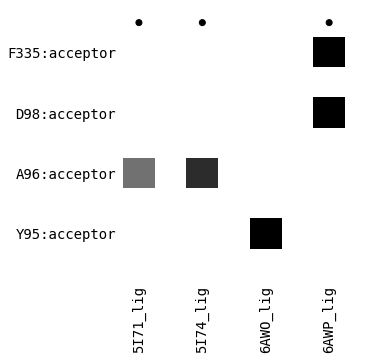

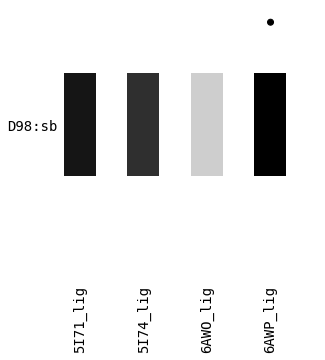

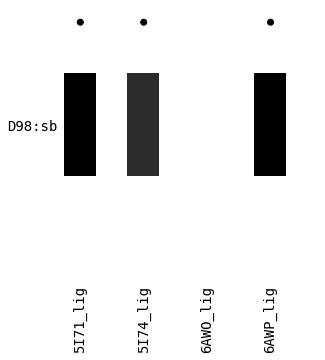

F2
{'1BCU_lig': 0, '1BHX_lig': 0, '1C1U_lig': 4, '1C1V_lig': 14, '1C4U_lig': 0, '1C5N_lig': 0, '1C5O_lig': 0, '1D3D_lig': 1, '1D3P_lig': 1, '1D4P_lig': 0, '1D6W_lig': 24, '1D9I_lig': 1, '1FPC_lig': 13, '1G30_lig': 9, '1G32_lig': 0, '1GHV_lig': 2, '1GHW_lig': 3, '1GHY_lig': 2, '1K21_lig': 0, '1K22_lig': 3}


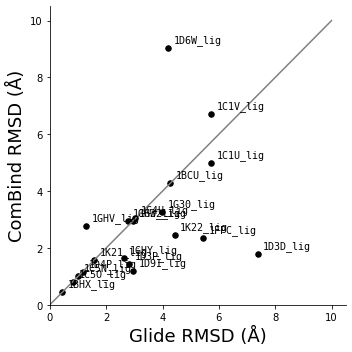

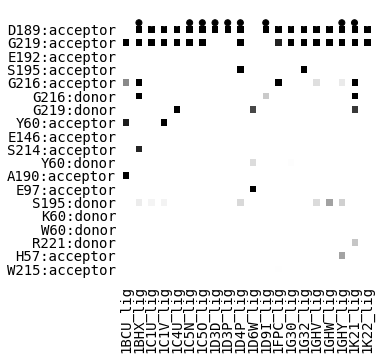

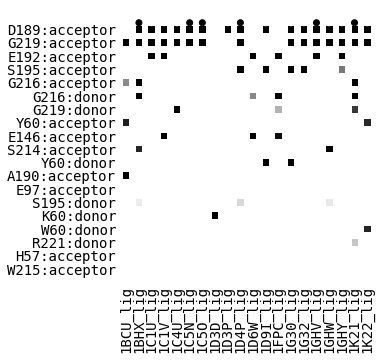

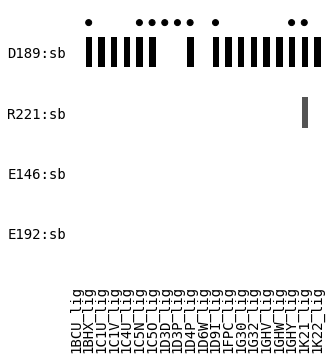

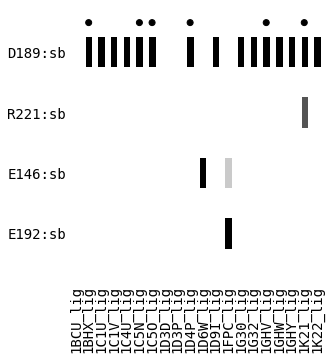

AR
{'1E3G_lig': 34, '1T5Z_lig': 0, '2AM9_lig': 0, '2AMB_lig': 0, '2AX9_lig': 1, '2HVC_lig': 1, '3B5R_lig': 0, '3B65_lig': 36, '3B66_lig': 21, '3B67_lig': 0, '3B68_lig': 3, '3RLJ_lig': 55, '3V49_lig': 0, '3V4A_lig': 0, '4QL8_lig': 0, '5CJ6_lig': 65, '5T8E_lig': 0, '5T8J_lig': 0, '5V8Q_lig': 0}


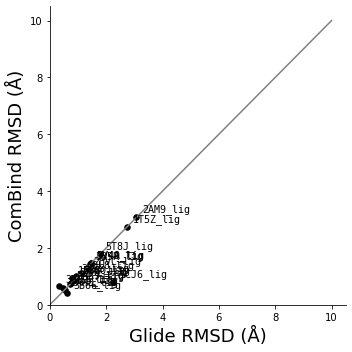

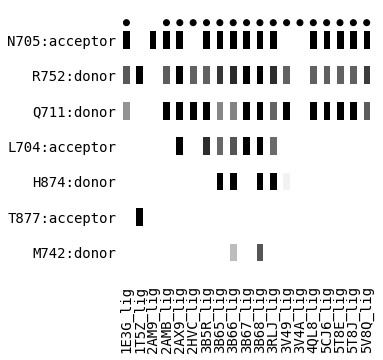

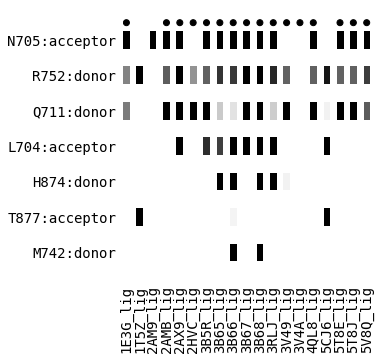

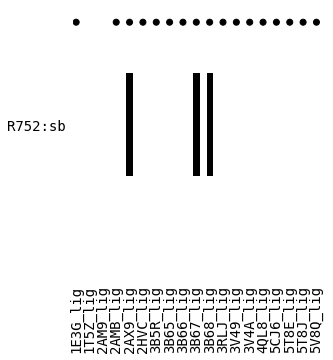

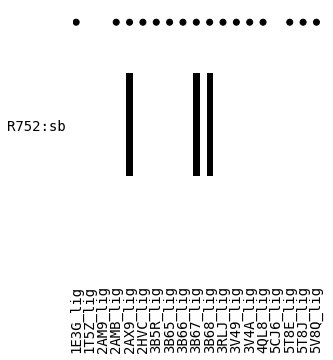

ERA
{'1ERR_lig': 1, '1GWQ_lig': 0, '1L2I_lig': 0, '1R5K_lig': 0, '1SJ0_lig': 2, '1UOM_lig': 0, '1X7E_lig': 10, '1X7R_lig': 46, '1XP1_lig': 0, '1XP6_lig': 0, '1XP9_lig': 1, '1XPC_lig': 1, '1XQC_lig': 0, '1YIM_lig': 41, '1YIN_lig': 2, '1ZKY_lig': 11, '2AYR_lig': 1, '2B1V_lig': 0, '2B1Z_lig': 0, '2FAI_lig': 0}


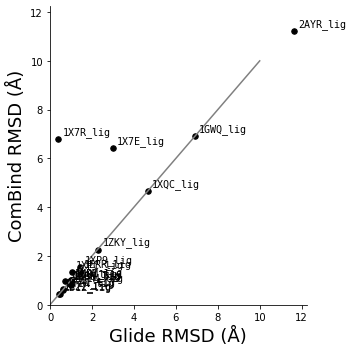

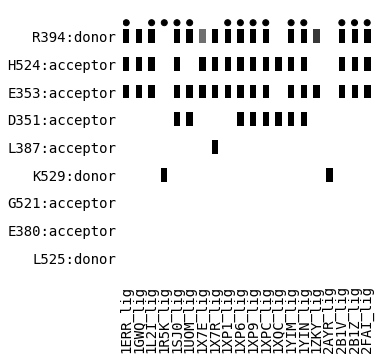

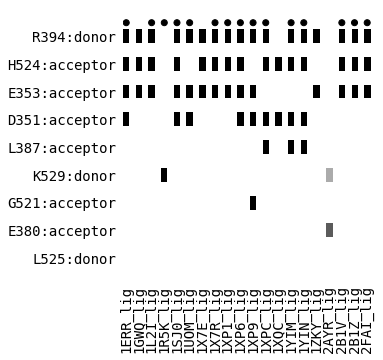

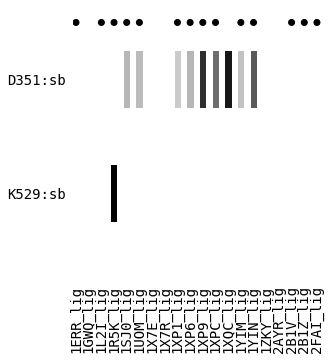

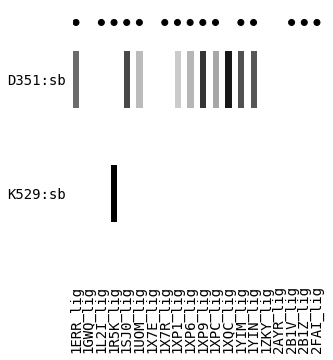

HSP90AA1
{'1YC4_lig': 8, '1YET_lig': 7, '2QFO_lig': 9, '2QG0_lig': 27, '2QG2_lig': 1, '2UWD_lig': 0, '2XAB_lig': 0, '2XDK_lig': 4, '2XDL_lig': 86, '2XDX_lig': 3, '2XHT_lig': 11, '2XJG_lig': 0, '2XJJ_lig': 1, '2XJX_lig': 19, '2YI0_lig': 1, '2YI7_lig': 0, '2YKI_lig': 3, '3B24_lig': 0, '3B25_lig': 1, '3B26_lig': 10}


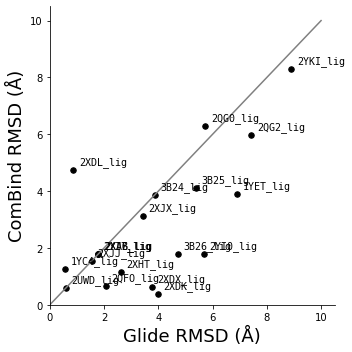

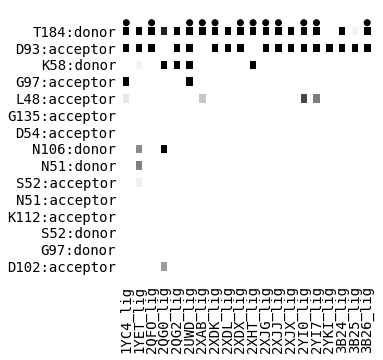

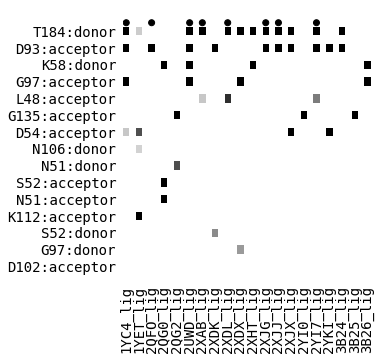

failed


In [4]:
path ='/Users/jpaggi/sherlock/oak/users/jpaggi/bpp_data'

_stats = 'stats41/stats'
scores = 'stats41/pdb/standard/1.0-mcss_contact_hbond_sb'
fname = 'pdb.sc'

for prot in proteins:
    print(prot)
    try:
        plot()
    except:
        print('failed')